In [26]:
import numpy as np
import pylab as plt
from scipy.signal import csd
import torch
from torch import optim
from nflows import transforms, distributions, flows
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
plt.rcParams.update({'font.size': 18})

In [2]:
background = np.load('Datasets/background.npz')['data']
bbh = np.load('Datasets/bbh_for_challenge.npy')
sglf = np.load('Datasets/sglf_for_challenge.npy')

In [3]:
N_total = background.shape[0]
background_cs = np.zeros((N_total, 101))
bbh_cs = np.zeros((bbh.shape[0], 101))
sglf_cs = np.zeros((sglf.shape[0], 101))
for i in range(N_total):
    f, Pxx = csd(background[i,0,:], background[i,1,:])
    background_cs[i] = np.abs(Pxx)

    f, Pxx = csd(bbh[i,0,:], bbh[i,1,:])
    bbh_cs[i] = np.abs(Pxx)

    f, Pxx = csd(sglf[i,0,:], sglf[i,1,:])
    sglf_cs[i] = np.abs(Pxx)

/Users/ASK126/miniconda3/envs/myenv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


In [4]:
x = background_cs
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_train, x_val = train_test_split(x_scaled, test_size=0.2, random_state=42)

from sklearn.decomposition import PCA
pca = PCA(n_components=70)  # Retain 100 dimensions
x_train_pca = pca.fit_transform(x_train)
x_val_pca = pca.transform(x_val)

explained_variance_ratio = pca.explained_variance_ratio_

# Total variance retained
total_variance_retained = np.sum(explained_variance_ratio)
print(f"Total Variance Retained: {total_variance_retained:.2%}")


Total Variance Retained: 95.07%


In [5]:
d = x_train_pca.shape[1]
num_layers = 3

base_dist = distributions.StandardNormal(shape=[d])
transforms_array = []

for _ in range(num_layers):
    transforms_array.append(transforms.ReversePermutation(features=d))
    transforms_array.append(transforms.MaskedAffineAutoregressiveTransform(features=d, hidden_features=16))

transform = transforms.CompositeTransform(transforms_array)

flow = flows.Flow(transform, base_dist)

lr = 1e-2
optimizer = optim.Adam(flow.parameters(), lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,800], gamma=0.1)


In [6]:
batch_size = 5000
n_epochs = 60
N_train = x_train_pca.shape[0]
n_batches = N_train // batch_size

epoch_losses = []
val_losses = []
for epoch in range(n_epochs):
    flow.train()
    batch_losses = []
    for i in range(n_batches):
        batch_inds = np.random.choice(N_train, size=batch_size, replace=False)
        x_batch = torch.tensor(x_train_pca[batch_inds], dtype=torch.float32)
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=x_batch).mean()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    epoch_losses.append(np.mean(batch_losses))

    flow.eval()
    val_loss = -flow.log_prob(torch.tensor(x_val_pca, dtype=torch.float32)).mean().item()
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {epoch_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, LR: {scheduler.get_last_lr()[0]:.2e}")

    scheduler.step()

Epoch 1/60, Train Loss: 7722.7584, Val Loss: 111.2566, LR: 1.00e-02
Epoch 2/60, Train Loss: 112.2248, Val Loss: 109.9970, LR: 1.00e-02
Epoch 3/60, Train Loss: 110.1955, Val Loss: 105.8898, LR: 1.00e-02
Epoch 4/60, Train Loss: 110.6461, Val Loss: 104.5220, LR: 1.00e-02
Epoch 5/60, Train Loss: 104.3822, Val Loss: 103.5229, LR: 1.00e-02
Epoch 6/60, Train Loss: 103.6267, Val Loss: 102.8885, LR: 1.00e-02
Epoch 7/60, Train Loss: 102.9846, Val Loss: 102.4706, LR: 1.00e-02
Epoch 8/60, Train Loss: 102.5376, Val Loss: 102.1575, LR: 1.00e-02
Epoch 9/60, Train Loss: 102.2892, Val Loss: 101.9331, LR: 1.00e-02
Epoch 10/60, Train Loss: 102.0201, Val Loss: 101.7554, LR: 1.00e-02
Epoch 11/60, Train Loss: 101.9269, Val Loss: 101.6107, LR: 1.00e-02
Epoch 12/60, Train Loss: 101.7732, Val Loss: 101.4933, LR: 1.00e-02
Epoch 13/60, Train Loss: 101.6528, Val Loss: 101.4007, LR: 1.00e-02
Epoch 14/60, Train Loss: 101.6727, Val Loss: 101.3438, LR: 1.00e-02
Epoch 15/60, Train Loss: 101.4437, Val Loss: 101.2632, L

(0.0, 200.0)

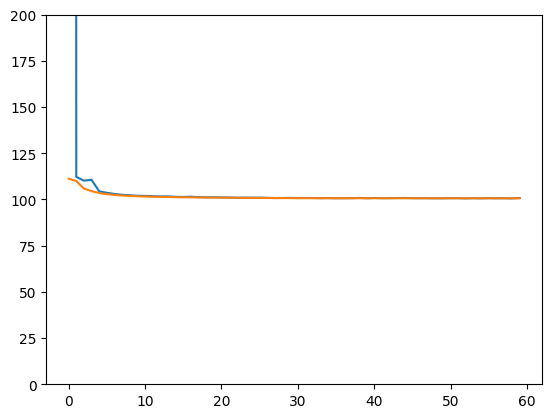

In [7]:
fig, ax = plt.subplots()

ax.plot(epoch_losses, label='Train Loss')
ax.plot(val_losses, label='Val Loss')
ax.set_ylim(0,200)


In [8]:
background_log_probs = flow.log_prob(torch.tensor(pca.transform(x_scaled), dtype=torch.float32)).detach().numpy()
background_latents = flow.transform_to_noise(torch.tensor(pca.transform(x_scaled), dtype=torch.float32)).detach().numpy()

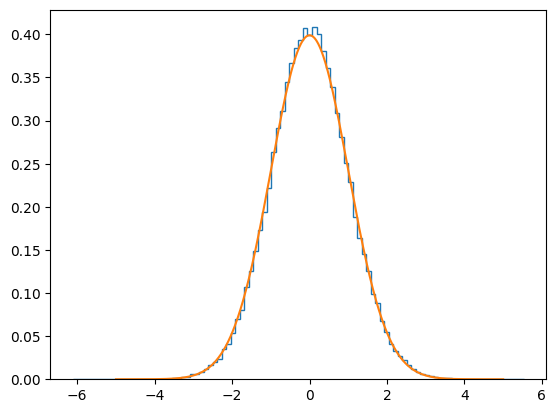

In [9]:
fig, ax = plt.subplots()

ax.hist(background_latents[:,3], bins=100, histtype='step', density=True);
x_plot = np.linspace(-5, 5, 1000)
ax.plot(x_plot, np.exp(-0.5*x_plot**2)/np.sqrt(2*np.pi), label='Standard Normal')

In [10]:
sglf_log_probs = flow.log_prob(torch.tensor(pca.transform(scaler.transform(sglf_cs)), dtype=torch.float32)).detach().numpy()
bbh_log_probs = flow.log_prob(torch.tensor(pca.transform(scaler.transform(bbh_cs)), dtype=torch.float32)).detach().numpy()

Text(0.5, 0, 'Log Probability')

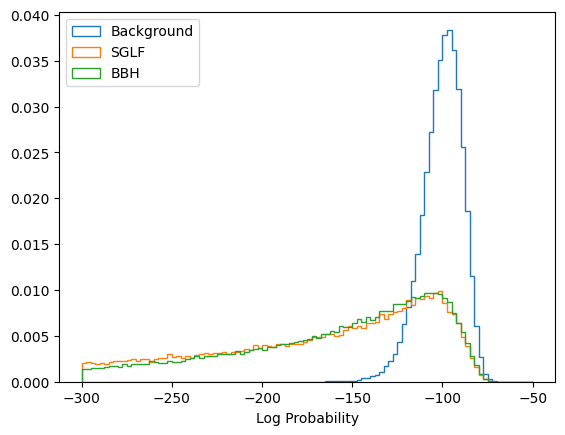

In [11]:
fig, ax = plt.subplots()

ax.hist(background_log_probs, bins=100, range=(-300,-50), histtype='step', density=True, label='Background');
ax.hist(sglf_log_probs, bins=100, range=(-300,-50), histtype='step', density=True, label='SGLF');
ax.hist(bbh_log_probs, bins=100, range=(-300,-50), histtype='step', density=True, label='BBH');
ax.legend()
ax.set_xlabel('Log Probability')

Text(0, 0.5, 'Signal')

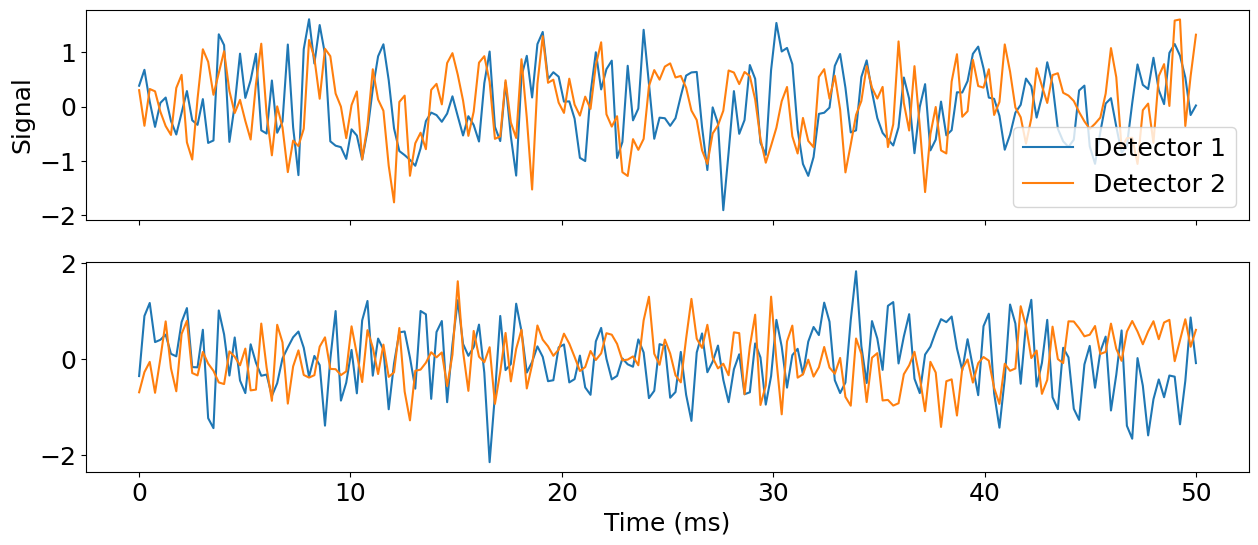

In [ ]:
time_x = np.linspace(0, 50, 200)

sorter = np.argsort(background_log_probs)
i_background = sorter[np.searchsorted(background_log_probs, -100, sorter=sorter)]
sorter = np.argsort(bbh_log_probs)
i_bbh = sorter[np.searchsorted(bbh_log_probs, -120, sorter=sorter)]

fig, ax = plt.subplots(nrows=2, figsize=(15,6), sharex=True)
fig.subplots_adjust(hspace=0)
ax[0].plot(time_x, background[i_background,0,:], label='Detector 1')
ax[0].plot(time_x, background[i_background,1,:], label='Detector 2')
ax[1].plot(time_x, bbh[i_bbh,0,:])
ax[1].plot(time_x, bbh[i_bbh,1,:])
ax[0].legend()

ax[1].set_xlabel('Time (ms)')
ax[0].set_ylabel('Signal')

Text(0, 0.5, 'Signal')

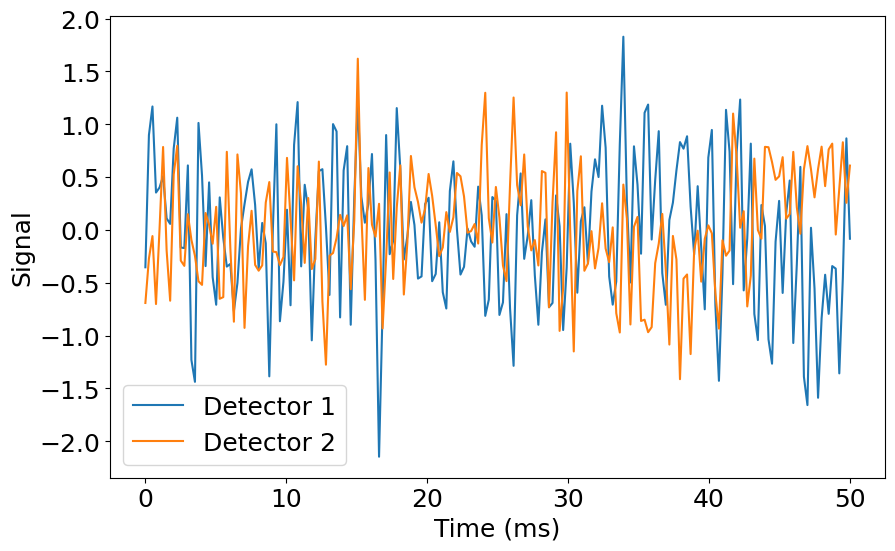

In [ ]:


fig, ax = plt.subplots(figsize=(10,6))
ax.plot(time_x, bbh[i_bbh,0,:], label='Detector 1')
ax.plot(time_x, bbh[i_bbh,1,:], label='Detector 2')
ax.legend()
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Signal')

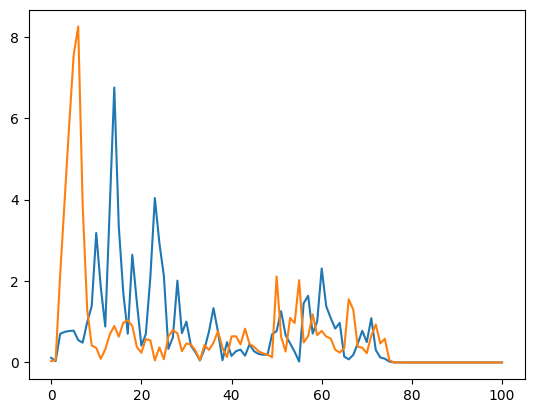

In [23]:
fig, ax = plt.subplots()

ax.plot(background_cs[i_background], label='Background')
ax.plot(bbh_cs[i_bbh], label='BBH')


In [12]:
probability_array = np.linspace(-150, -50, 100)

fpr = []
tpr_bbh = []
tpr_sglf = []

for p in probability_array:
    fp = np.sum(background_log_probs < p)
    tn = np.sum(background_log_probs >= p)
    fpr.append(fp / (fp + tn))

    tp_bbh = np.sum(bbh_log_probs < p)
    tp_sglf = np.sum(sglf_log_probs < p)

    fn_bbh = np.sum(bbh_log_probs >= p)
    fn_sglf = np.sum(sglf_log_probs >= p)

    tpr_bbh.append(tp_bbh / (tp_bbh + fn_bbh))
    tpr_sglf.append(tp_sglf / (tp_sglf + fn_sglf))


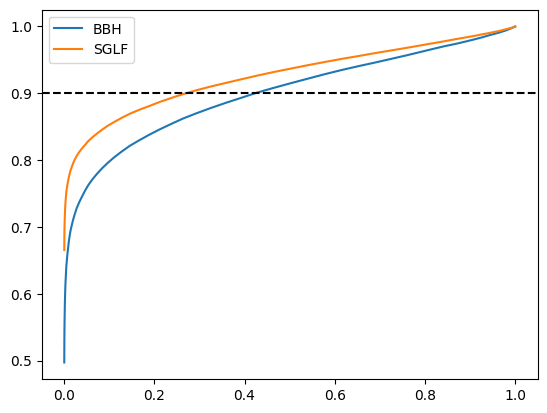

In [13]:
fig, ax = plt.subplots()

ax.plot(fpr, tpr_bbh, label='BBH')
ax.plot(fpr, tpr_sglf, label='SGLF')
ax.legend()
ax.axhline(0.9, color='black', linestyle='--')

In [14]:
#torch.save(flow.state_dict(), 'flow_model.pth')

In [15]:
# import pickle 

# with open('pca_model.pkl', 'wb') as f:
#     pickle.dump(pca, f)

# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

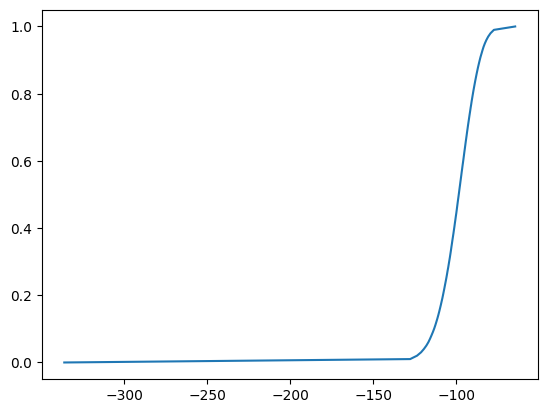

In [17]:
quantiles = np.linspace(0, 1, 100)
quantile_values = np.quantile(background_log_probs, quantiles)

fig, ax = plt.subplots()
ax.plot(quantile_values, quantiles)

In [21]:
bbh_quantiles = np.zeros(N_total)
sglf_quantiles = np.zeros(N_total)
background_quantiles = np.zeros(N_total)
for i in range(N_total):
    bbh_single_log_prob = bbh_log_probs[i]
    bbh_quantiles[i] = np.interp(bbh_single_log_prob, quantile_values, quantiles)

    sglf_single_log_prob = sglf_log_probs[i]
    sglf_quantiles[i] = np.interp(sglf_single_log_prob, quantile_values, quantiles)

    background_single_log_prob = background_log_probs[i]
    background_quantiles[i] = np.interp(background_single_log_prob, quantile_values, quantiles)



In [31]:
np.save('quantiles.npy', quantiles)
np.save('quantile_values.npy', quantile_values)

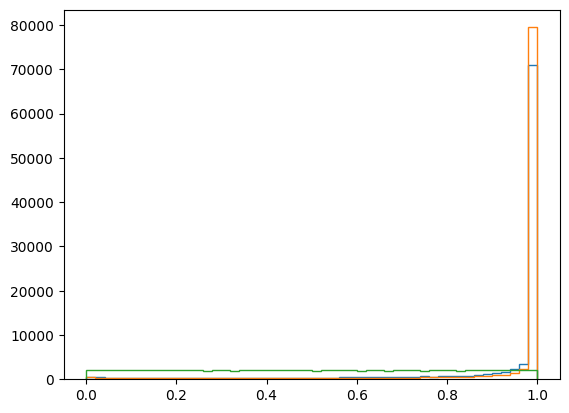

In [30]:
fig, ax = plt.subplots()

ax.hist(1-bbh_quantiles, bins=50, histtype='step', label='BBH');
ax.hist(1-sglf_quantiles, bins=50, histtype='step', label='SGLF');
ax.hist(1-background_quantiles, bins=50, histtype='step', label='Background');

In [27]:
bbh_probs = 1-bbh_quantiles
sglf_probs = 1-sglf_quantiles
background_probs = 1-background_quantiles

In [28]:
p_array = np.linspace(0, 1, 100)

fpr = []
tpr_bbh = []
tpr_sglf = []

for p in p_array:
    fp = np.sum(background_probs > p)
    tn = np.sum(background_probs <= p)
    fpr.append(fp / (fp + tn))

    tp_bbh = np.sum(bbh_probs > p)
    tp_sglf = np.sum(sglf_probs > p)

    fn_bbh = np.sum(bbh_probs <= p)
    fn_sglf = np.sum(sglf_probs <= p)

    tpr_bbh.append(tp_bbh / (tp_bbh + fn_bbh))
    tpr_sglf.append(tp_sglf / (tp_sglf + fn_sglf))


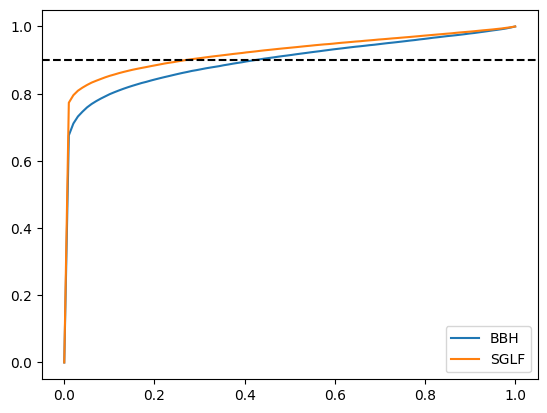

In [29]:
fig, ax = plt.subplots()

ax.plot(fpr, tpr_bbh, label='BBH')
ax.plot(fpr, tpr_sglf, label='SGLF')
ax.legend()
ax.axhline(0.9, color='black', linestyle='--')

In [36]:
#import model
import importlib
importlib.reload(model)

<module 'model' from '/Users/ASK126/Desktop/research/gw_challenge/model.py'>

In [37]:
test_model = model.Model()

In [39]:
test_model.load()
test_bbh = test_model.predict(bbh)

/Users/ASK126/miniconda3/envs/myenv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


In [40]:
bbh_probs, test_bbh

(array([0.99614928, 0.99481803, 0.99135294, ..., 0.99263475, 0.82591994,
        0.99246748]),
 array([0.99341342, 0.99273985, 0.98173419, ..., 0.99297751, 0.99152971,
        0.99271571]))